<a href="https://colab.research.google.com/github/GabrielGuilherme88/Long-and-Short.R/blob/master/TAP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Elaboração de scripts em python para análise de dados referente ao estudo demandado pela Agência Nacional de Saúde (ANS)

Como série, estaremos analisando os dados da pesquisa de preços FIPE, voltada para a cesta de produtos da saúde e suas variações mensais.

Os dados foram coletados no IPEADATA (Instituto de Pesquisa Econômica) na sessão de macroeconomia. A periodicidade está mensal.

Foi feito um ajuste nos dados originais, excluindo dados que fossem anteriores a 1998 por conta do controle do processo inflacionário provindo do plano real (1994). Com isso evitamos grandes variaçõe em nossa amostra.

A metodologia adotada é com base no livro Econometria Básica de Damodar N. Gujarati e Dawn C. Porter em sua quinta edição.

Portanto, seguiremos a análise na ordem:
1° será feito uma plotagem dos dados, assim como sua distribuição.
2° plotagem para verificar a existência de sazonalidade
3° plotagem os gráficos de autocorrelação e autocorrelação parcial (respectivamente ACF e PACF) para verificar White Noise e estacionáriedade (visualmente)
4° teste de estacionáriedade com o teste ADF para verificar o comportamento dos dados (se estão róximos de White Noise)
5° Estimação do modelo arima e de seus outputs estatísticos


In [13]:
pip install pmdarima

In [40]:
#Carregando as bibliotecas necessárias para a análise.
import pandas as pd
import numpy as np
import seaborn as sns
import io
from google.colab import files
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (16.0, 8.0)
import statsmodels.api as sm
import statsmodels.tsa as tsa
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import pmdarima as pm
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.seasonal import seasonal_decompose


In [41]:
# Importa dados com indexador. Os dados estão armazenados em meu github pessoal
df = pd.read_csv("https://gist.githubusercontent.com/GabrielGuilherme88/d09a4c6aeeb870170fefbf207cee554a/raw/3e6267fb8f4a7105d56736e18540d69146a1891d/TESTE%2520P.csv",
                 delimiter=';', header=0, index_col= 0)

In [43]:
#Para verificar se os dados foram importados 
df.head()

,Precos_FIPE,media,DP_plus,DP_sub
Data,,,,
1995.10,0.0129,0.007158,0.023456,-0.006544
1995.11,0.0045,0.007158,0.023456,-0.006544
1995.12,0.0288,0.007158,0.023456,-0.006544
1996.01,0.0277,0.007158,0.023456,-0.006544
1996.02,0.0092,0.007158,0.023456,-0.006544


In [42]:
#Para retirar os anos próximos ao inicio do plano real
df.drop(df.index[:15], inplace=True)

In [44]:
#Estatística descritiva da FIPE saúde
df["Precos_FIPE"].describe()

count    304.000000
mean       0.006056
std        0.005444
min       -0.006099
25%        0.002789
50%        0.004806
75%        0.007996
max        0.043900
Name: Precos_FIPE, dtype: float64

<Figure size 1296x576 with 0 Axes>

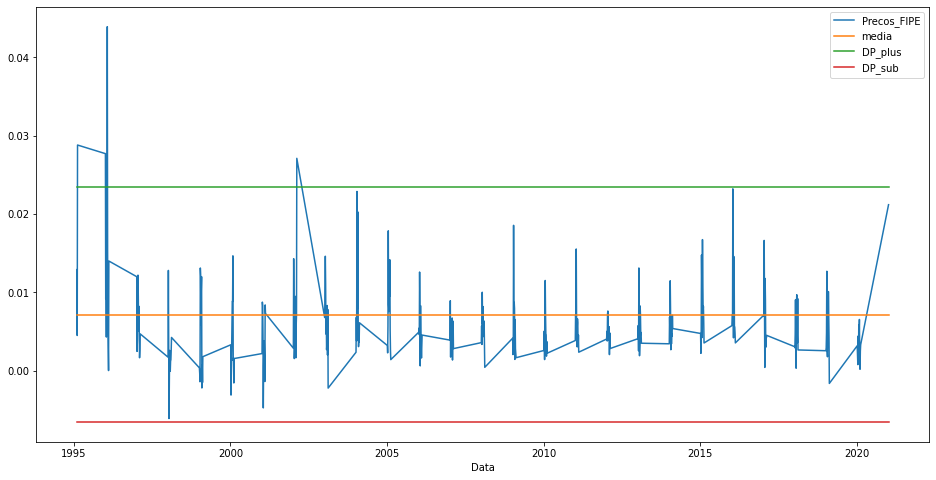

In [45]:
#Gráfico para visualizar a média e desvio padrão. Aparentemente trata-se de uma série white noise estacionária. 
plt.figure(figsize=(18, 8))
df.plot()

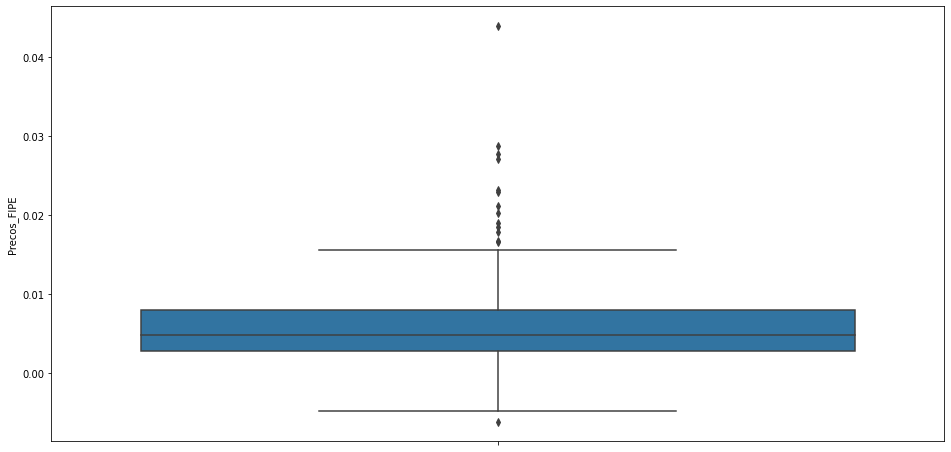

In [49]:
sns.boxplot(y="Precos_FIPE", data=df)

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


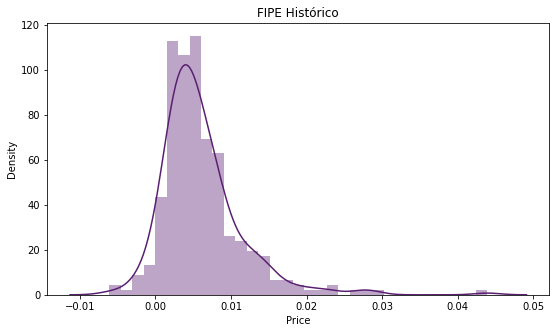

In [64]:
sns.set_color_codes(palette='dark')

f, ax = plt.subplots(figsize=(9, 5))
sns.distplot(df['Precos_FIPE'], color="m", axlabel='Price')
ax.set(title="FIPE Histórico")
plt.show()

<Figure size 1152x576 with 0 Axes>

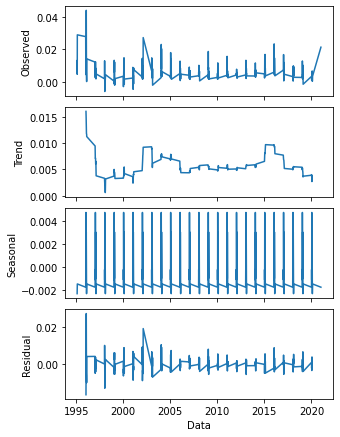

In [52]:

result = seasonal_decompose(df['Precos_FIPE'], model='additive', freq=12)

fig = plt.figure()  
fig = result.plot()  
fig.set_size_inches(4, 6)

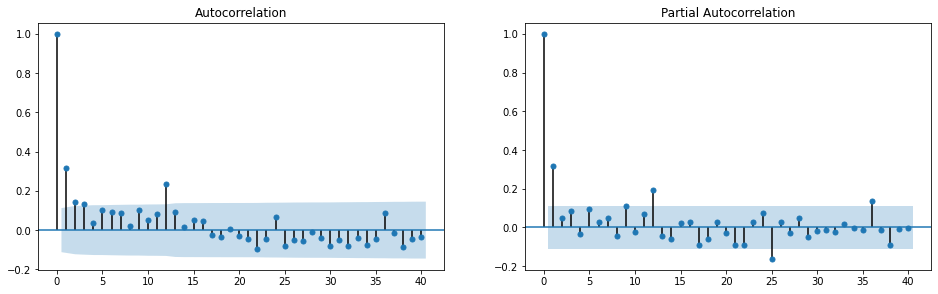

In [46]:
#uma função para calcular e plotar a autocorrelação e autocorrelação parcial da FIPE saúde
#Aparentemente os dados não possuem forte relação com seus próprios erros ao longo de suas defasagem. Isso indica que é necessário no máximo 2 defasagens no modelo ARIMA
#Também temos indicío de que se trata de uma série estacinária.
def acf_pacf(x):
    fig = plt.figure(figsize=(16,10))
    ax1 = fig.add_subplot(221)
    fig = sm.graphics.tsa.plot_acf(x, lags=40, ax=ax1)
    ax2 = fig.add_subplot(222)
    fig = sm.graphics.tsa.plot_pacf(x, lags=40, ax=ax2)
acf_pacf(df["Precos_FIPE"])

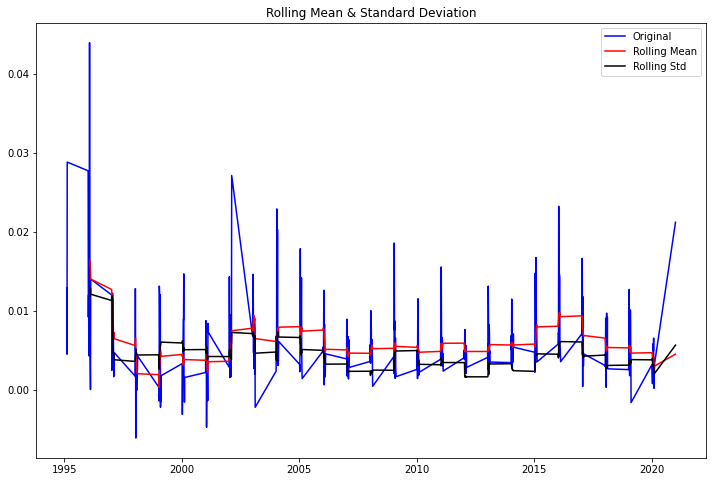

Results of Dickey-Fuller Test:
p-value = 0.0000. The series is likely stationary.
Test Statistic                  -5.098654
p-value                          0.000014
#Lags Used                      11.000000
Number of Observations Used    292.000000
Critical Value (1%)             -3.452945
Critical Value (5%)             -2.871490
Critical Value (10%)            -2.572071
dtype: float64


In [47]:
#Para verificar a estacionáriedade, podemos utilizar o teste ADF.
#O código abaixo cria uma função que irá realizar o teste em nossa variável chave, assim como plotar um gráfico com suas defasagens regredidas. 
def test_stationarity(timeseries, window = 12, cutoff = 0.01):

    #Determing rolling statistics
    rolmean = timeseries.rolling(window).mean()
    rolstd = timeseries.rolling(window).std()

    #Plot rolling statistics:
    fig = plt.figure(figsize=(12, 8))
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show()
    
    #Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC', maxlag = 20 )
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    pvalue = dftest[1]
    if pvalue < cutoff:
        print('p-value = %.4f. The series is likely stationary.' % pvalue)
    else:
        print('p-value = %.4f. The series is likely non-stationary.' % pvalue)
    
    print(dfoutput)
test_stationarity(df['Precos_FIPE'])

In [117]:
#Auto arima -> escolhe automaticamente os parametros de defasagem e de médi móvel com base no criterio de Akaike. No caso, o melhor modelo indicado é o ARIMA (2,0,2)
model = pm.auto_arima(df.Precos_FIPE, start_p=1, start_q=1,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=3, max_q=3, # maximum p and q
                      m=1,              # frequency of series
                      d=None,           # let model determine 'd'
                      seasonal=False,   # No Seasonality
                      start_P=0, 
                      D=0, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)

print(model.summary())

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=-2296.102, Time=0.05 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=-2060.569, Time=0.07 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=-2259.946, Time=0.05 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=-2179.803, Time=0.09 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=-2200.084, Time=0.33 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=-2323.591, Time=0.22 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=-2205.423, Time=0.15 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=-2312.670, Time=0.17 sec
 ARIMA(1,0,3)(0,0,0)[0]             : AIC=-2321.492, Time=0.13 sec
 ARIMA(0,0,3)(0,0,0)[0]             : AIC=-2241.251, Time=0.49 sec
 ARIMA(2,0,3)(0,0,0)[0]             : AIC=-2320.509, Time=0.54 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=-2333.553, Time=0.82 sec
 ARIMA(0,0,2)(0,0,0)[0] intercept   : AIC=-2330.649, Time=0.70 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=-2333.337, Time=0.20 sec
 ARIMA(2,0,2)(0,0,0

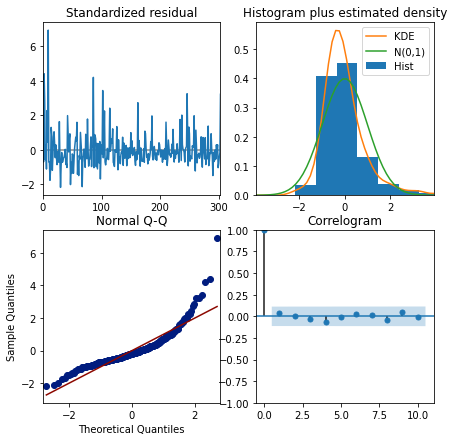

In [54]:
model.plot_diagnostics(figsize=(7,7))
plt.show()


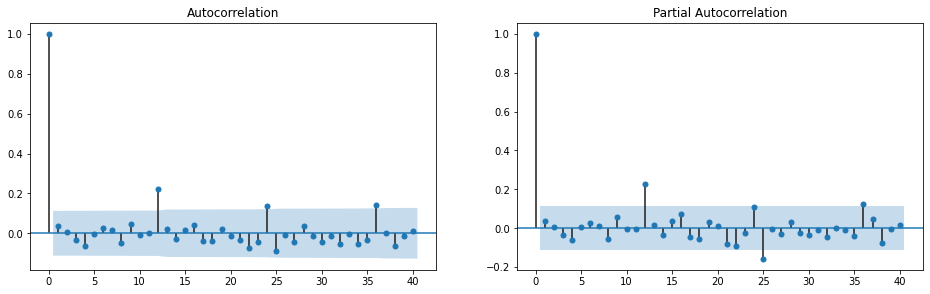

In [61]:
#Autocorrelação dos residuos
#Aparentemente, os resíduos são estacionários
residuals = model.resid()
acf_pacf(residuals)

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


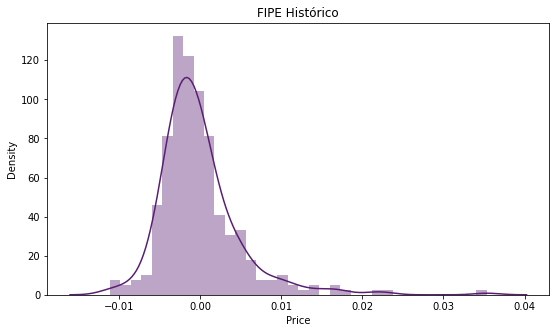

In [65]:
#Distribuição dos residuos
sns.set_color_codes(palette='dark')

f, ax = plt.subplots(figsize=(9, 5))
sns.distplot(residuals, color="m", axlabel='Price')
ax.set(title="FIPE Histórico")
plt.show()

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


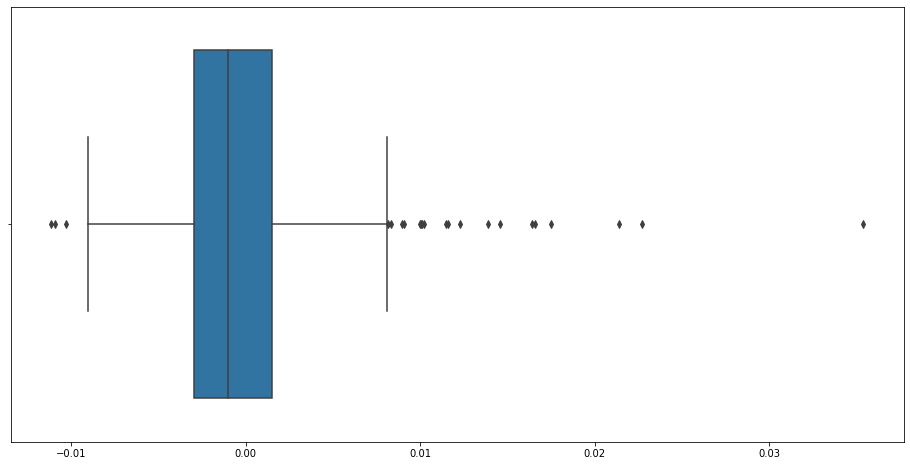

In [67]:
sns.boxplot(residuals, data=df)

In [73]:
teste = model.predict(96, alpha=0.05)
teste

array([0.00941788, 0.00661445, 0.00800395, 0.00656879, 0.00722345,
       0.00648446, 0.00678813, 0.00640507, 0.00654288, 0.00634283,
       0.00640337, 0.00629803, 0.00632331, 0.00626734, 0.00627698,
       0.00624695, 0.00624997, 0.0062337 , 0.00623412, 0.00622521,
       0.00622477, 0.00621984, 0.00621922, 0.00621647, 0.00621592,
       0.00621436, 0.00621394, 0.00621306, 0.00621276, 0.00621225,
       0.00621204, 0.00621175, 0.00621162, 0.00621144, 0.00621136,
       0.00621125, 0.0062112 , 0.00621114, 0.0062111 , 0.00621107,
       0.00621105, 0.00621103, 0.00621101, 0.006211  , 0.00621099,
       0.00621098, 0.00621098, 0.00621097, 0.00621097, 0.00621097,
       0.00621097, 0.00621096, 0.00621096, 0.00621096, 0.00621096,
       0.00621096, 0.00621096, 0.00621096, 0.00621096, 0.00621096,
       0.00621096, 0.00621096, 0.00621096, 0.00621096, 0.00621096,
       0.00621096, 0.00621096, 0.00621096, 0.00621096, 0.00621096,
       0.00621096, 0.00621096, 0.00621096, 0.00621096, 0.00621

In [79]:

mod = sm.tsa.statespace.SARIMAX(df["Precos_FIPE"],
                                order=(2, 0, 1),
                                seasonal_order=(1, 1, 1, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)

results = mod.fit()

print(results.summary().tables[1])

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:215: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  base index (or the model's index if the base index was not given) and


                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9666      0.078     12.340      0.000       0.813       1.120
ar.L2         -0.9924      0.055    -17.884      0.000      -1.101      -0.884
ma.L1         -3.2703      0.583     -5.608      0.000      -4.413      -2.127
ar.S.L12       0.1814      0.048      3.757      0.000       0.087       0.276
ma.S.L12      -1.9566      0.234     -8.351      0.000      -2.416      -1.497
sigma2      7.954e-07   3.25e-07      2.447      0.014    1.58e-07    1.43e-06


/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  return -self.score(params, *args) / nobs


In [119]:
teste2 = results.forecast(96, alpha=0.05)
teste2.head(96)

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:576: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  # Issue warnings for unsupported indexes


304    0.012908
305   -0.005380
306   -0.010491
307   -0.006701
308    0.012749
         ...   
395   -0.062135
396   -0.047043
397    0.021126
398    0.068193
399    0.060438
Length: 96, dtype: float64

In [116]:
model = sm.tsa.ARIMA(df["Precos_FIPE"].dropna(),(16,0,2)).fit(trend="nc")
print(model.summary())

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:215: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  base index (or the model's index if the base index was not given) and
/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  


                              ARMA Model Results                              
Dep. Variable:            Precos_FIPE   No. Observations:                  304
Model:                    ARMA(16, 2)   Log Likelihood                1189.920
Method:                       css-mle   S.D. of innovations              0.005
Date:                Fri, 12 Feb 2021   AIC                          -2341.840
Time:                        20:19:00   BIC                          -2271.216
Sample:                             0   HQIC                         -2313.589
                                                                              
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
ar.L1.Precos_FIPE      0.5067      0.060      8.380      0.000       0.388       0.625
ar.L2.Precos_FIPE     -0.9992      0.066    -15.179      0.000      -1.128      -0.870
ar.L3.Precos_FIPE   

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/arima_model.py:1441: RuntimeWarning: invalid value encountered in sqrt
  sigma2 = ssr/nobs, where ssr is the sum of squared residuals. If


/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:576: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  # Issue warnings for unsupported indexes
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:576: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  # Issue warnings for unsupported indexes


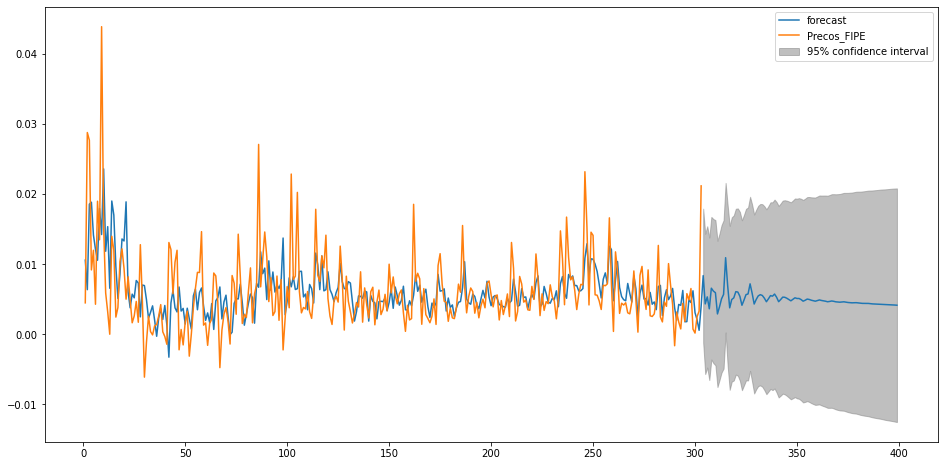

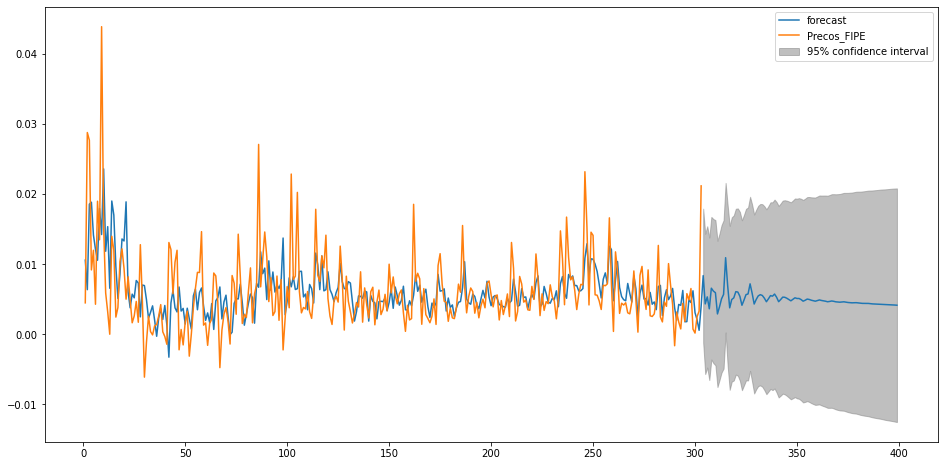

In [115]:
model.plot_predict(1,399)

In [ ]:
plot_predict